**CÁC GIẢI THUẬT PHÂN LOẠI CƠ BẢN**

*2.1. GIẢI THUẬT 1: CÂY QUYẾT ĐỊNH VÀ RỪNG CÂY*

2.1.1. Ôn tập lý thuyết


2.1.2. Bài làm mẫu

2.1.3. Bài tập thực hành 1
Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic lấy từ
https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset


**Nhiệm vụ 1: Xây dựng cây quyết định bằng thư viện Scikit-Learn**
1. Import thư viện

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import graphviz

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score


2. Nạp dữ liệu và tiền xử lý

In [ ]:
# Đọc dữ liệu
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

# Chọn các cột đặc trưng
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
full = pd.concat([train_df[features], test_df[features]], axis=0)

# Xử lý dữ liệu thiếu
full["Age"].fillna(full["Age"].median(), inplace=True)
full["Fare"].fillna(full["Fare"].median(), inplace=True)
full["Embarked"].fillna(full["Embarked"].mode()[0], inplace=True)

# One-hot encoding cho biến phân loại
full = pd.get_dummies(full, columns=["Sex","Embarked"], drop_first=True)

# Chia lại thành train & test
X_train = full.iloc[:len(train_df), :]
X_test = full.iloc[len(train_df):, :]
y_train = train_df["Survived"].values


/tmp/ipython-input-2071372016.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full["Age"].fillna(full["Age"].median(), inplace=True)
/tmp/ipython-input-2071372016.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

3. Chia train/test nhỏ hơn để đánh giá

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.2,
                                            random_state=24)

4. Xây dựng cây quyết định


In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_tr, y_tr)

print("Train acc:", accuracy_score(y_tr, dt.predict(X_tr)))
print("Validation acc:", accuracy_score(y_val, dt.predict(X_val)))

Train acc: 0.8188202247191011
Validation acc: 0.8156424581005587


5. Hiển thị cây quyết định

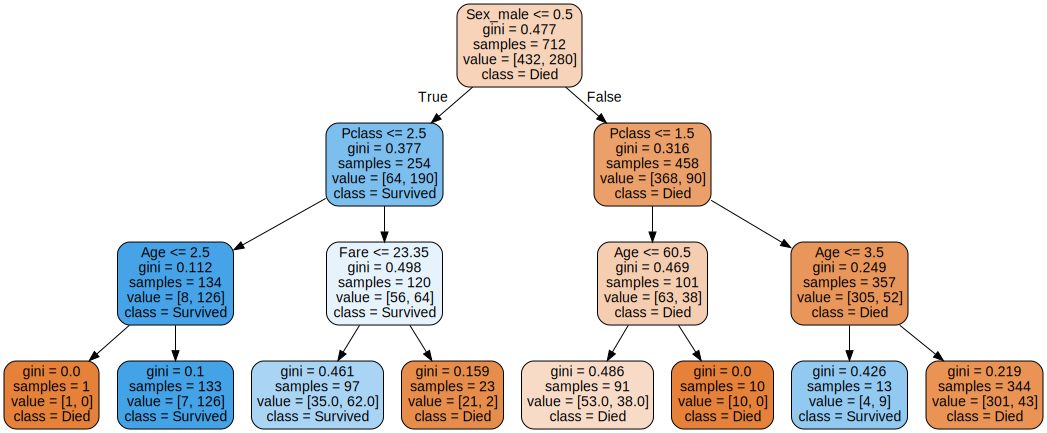

In [ ]:
dot_data = tree.export_graphviz(dt,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=X_tr.columns,
    class_names=['Died','Survived'])
graph = graphviz.Source(dot_data)
graph

**Nhiệm vụ 2: Tìm tham số tối ưu cho cây quyết định**

1. GridSearchCV để chọn tham số

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[2,3,4,5,6,8,10]}
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                       param_grid=params,
                       scoring='accuracy',
                       cv=4,
                       return_train_score=True,
                       verbose=1)
grid_dt.fit(X_train, y_train)

print("Best params:", grid_dt.best_params_)
print("Best CV score:", grid_dt.best_score_)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best params: {'max_depth': 6}
Best CV score: 0.8282834403910637


2. Vẽ biểu đồ theo max_depth

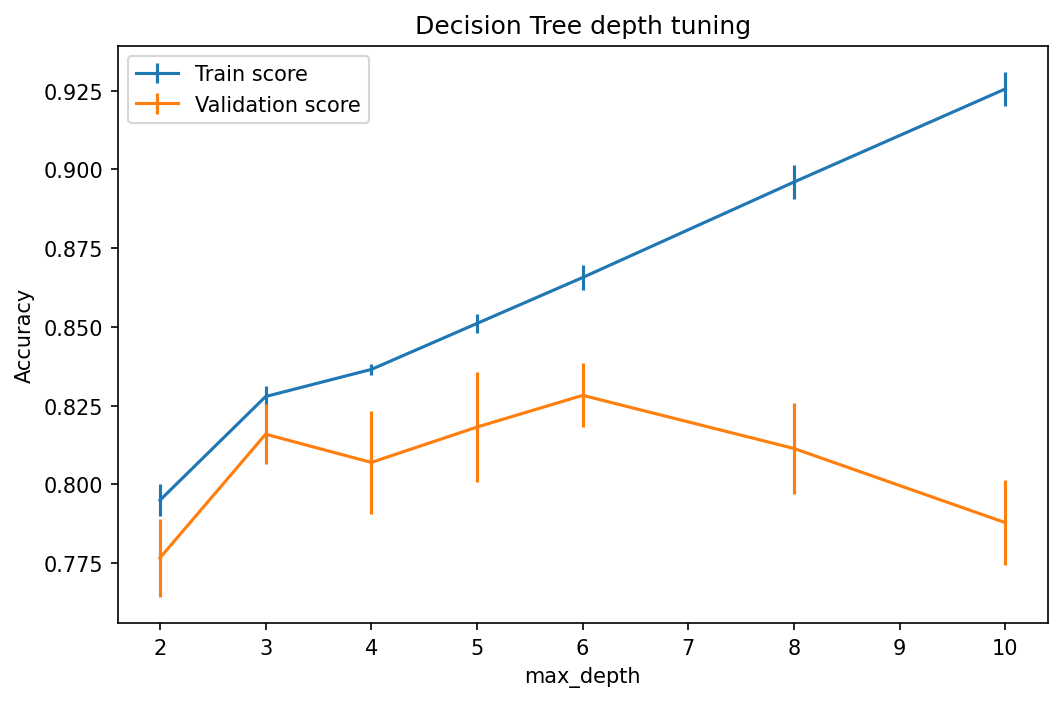

In [ ]:
cv_results_df = pd.DataFrame(grid_dt.cv_results_)

plt.figure(figsize=(8,5))
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_train_score'],
             yerr=cv_results_df['std_train_score']/np.sqrt(4),
             label='Train score')
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_test_score'],
             yerr=cv_results_df['std_test_score']/np.sqrt(4),
             label='Validation score')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree depth tuning')
plt.legend()
plt.show()

**Nhiệm vụ 3: Xây dựng rừng cây (Random Forest)**

1. Tạo mô hình Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators':list(range(10,110,10))}

cv_rf = GridSearchCV(rf,
                     param_grid=rf_params,
                     scoring='accuracy',
                     cv=4,
                     return_train_score=True,
                     verbose=1)
cv_rf.fit(X_train, y_train)

print("Best params:", cv_rf.best_params_)
print("Best CV score:", cv_rf.best_score_)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best params: {'n_estimators': 60}
Best CV score: 0.802478487456066


2. Vẽ biểu đồ số cây trong rừng

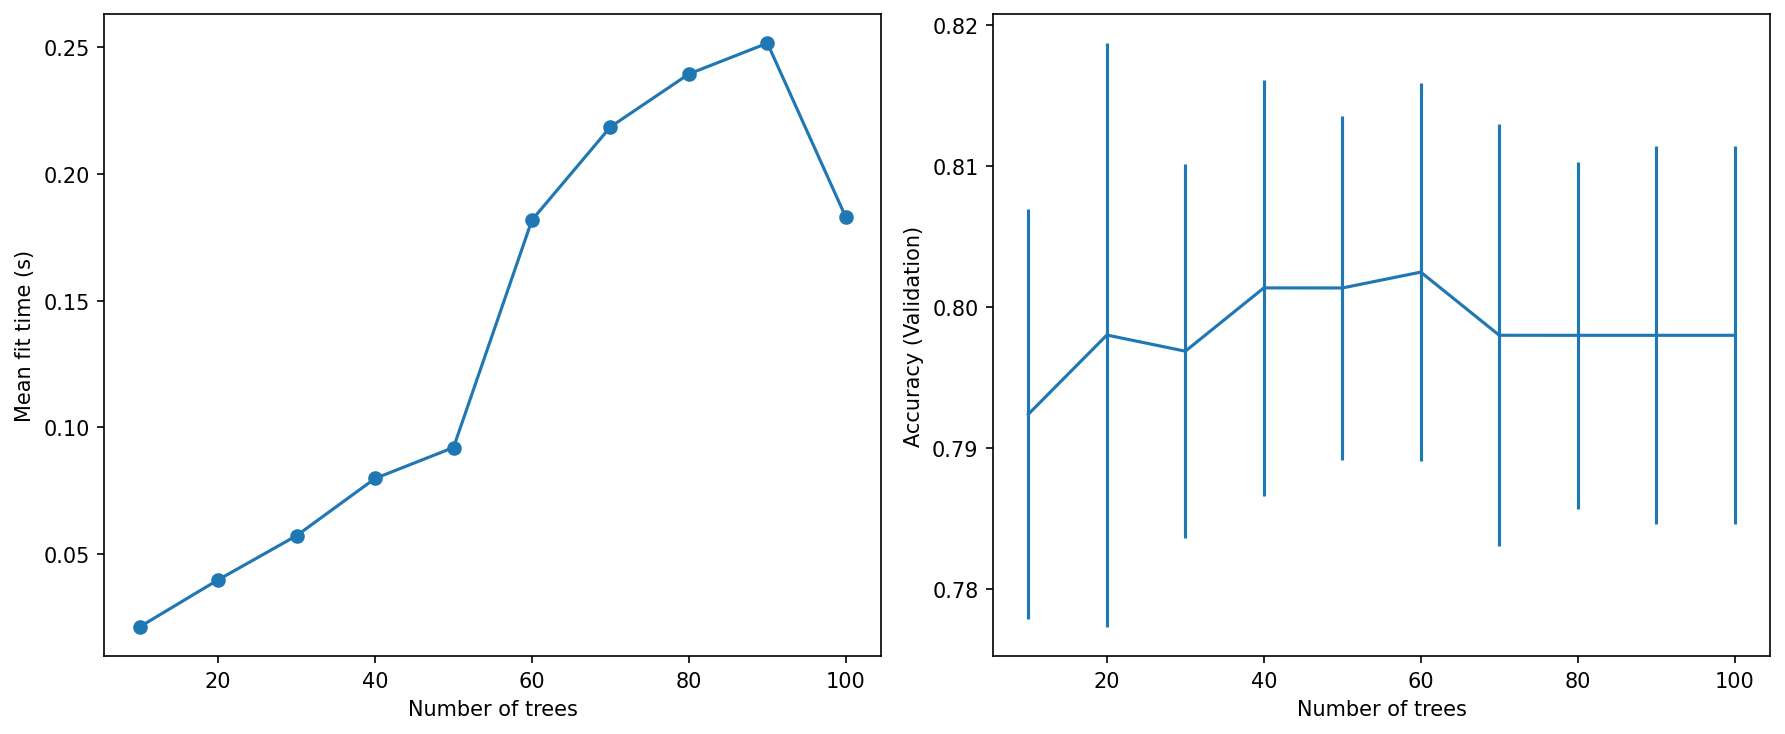

In [ ]:
cv_rf_results = pd.DataFrame(cv_rf.cv_results_)

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(cv_rf_results['param_n_estimators'], cv_rf_results['mean_fit_time'], '-o')
ax[0].set_xlabel('Number of trees')
ax[0].set_ylabel('Mean fit time (s)')

ax[1].errorbar(cv_rf_results['param_n_estimators'],
               cv_rf_results['mean_test_score'],
               yerr=cv_rf_results['std_test_score']/np.sqrt(4))
ax[1].set_xlabel('Number of trees')
ax[1].set_ylabel('Accuracy (Validation)')

plt.tight_layout()
plt.show()

3. Feature importance

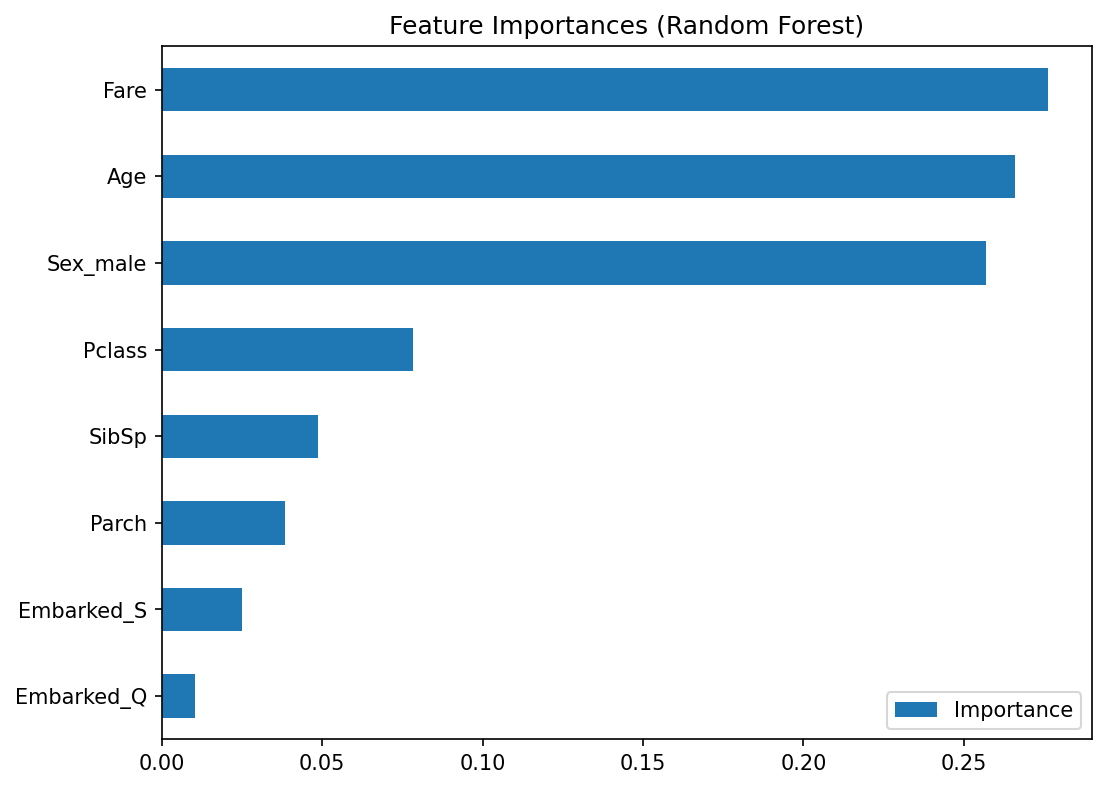

In [ ]:
feat_imp_df = pd.DataFrame({
    'Importance': cv_rf.best_estimator_.feature_importances_
}, index=X_train.columns)

feat_imp_df.sort_values('Importance', ascending=True).plot.barh(figsize=(8,6))
plt.title("Feature Importances (Random Forest)")
plt.show()

**2.1.4. Bài tập thực hành 2**

Xây dựng cây quyết định và rừng cây trên dữ liệu bệnh tiểu đường. Dữ liệu lấy từ
https://www.kaggle.com/code/tumpanjawat/diabetes-eda-random-forest-hp





**Nhiệm vụ 1: Xây dựng cây quyết định bằng thư viện Scikit-Learn**
1. Import thư viện



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

2. Nạp dữ liệu và phân tích sơ bộ

In [ ]:
# Đọc dữ liệu
df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Kích thước dữ liệu:", df.shape)
print(df.head())
print(df.info())
print(df['diabetes'].value_counts())

Kích thước dữ liệu: (100000, 9)
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null 

3. Chuẩn bị dữ liệu cho tập train/test

In [ ]:
# Xác định biến đầu vào và nhãn
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['gender', 'smoking_history'], drop_first=True)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

4. Xây dựng cây quyết định

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

print("Train acc:", accuracy_score(y_train, dt.predict(X_train)))
print("Test acc:", accuracy_score(y_test, dt.predict(X_test)))


Train acc: 0.9717625
Test acc: 0.9723


5. Hiển thị cây quyết định

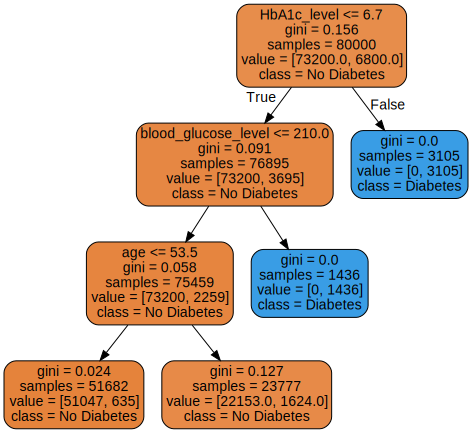

In [ ]:
dot_data = tree.export_graphviz(dt,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=X.columns,
    class_names=['No Diabetes','Diabetes'])
graph = graphviz.Source(dot_data)
graph

**Nhiệm vụ 2: Tìm tham số tối ưu cho cây quyết định**
1. GridSearchCV để chọn tham số


In [ ]:
params = {'max_depth':[2,3,4,5,6,8,10]}
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                       param_grid=params,
                       scoring='accuracy',
                       cv=4,
                       return_train_score=True,
                       verbose=1)
grid_dt.fit(X_train, y_train)

print("Best params:", grid_dt.best_params_)
print("Best CV score:", grid_dt.best_score_)


Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best params: {'max_depth': 2}
Best CV score: 0.9717625


2. Vẽ biểu đồ theo max_depth

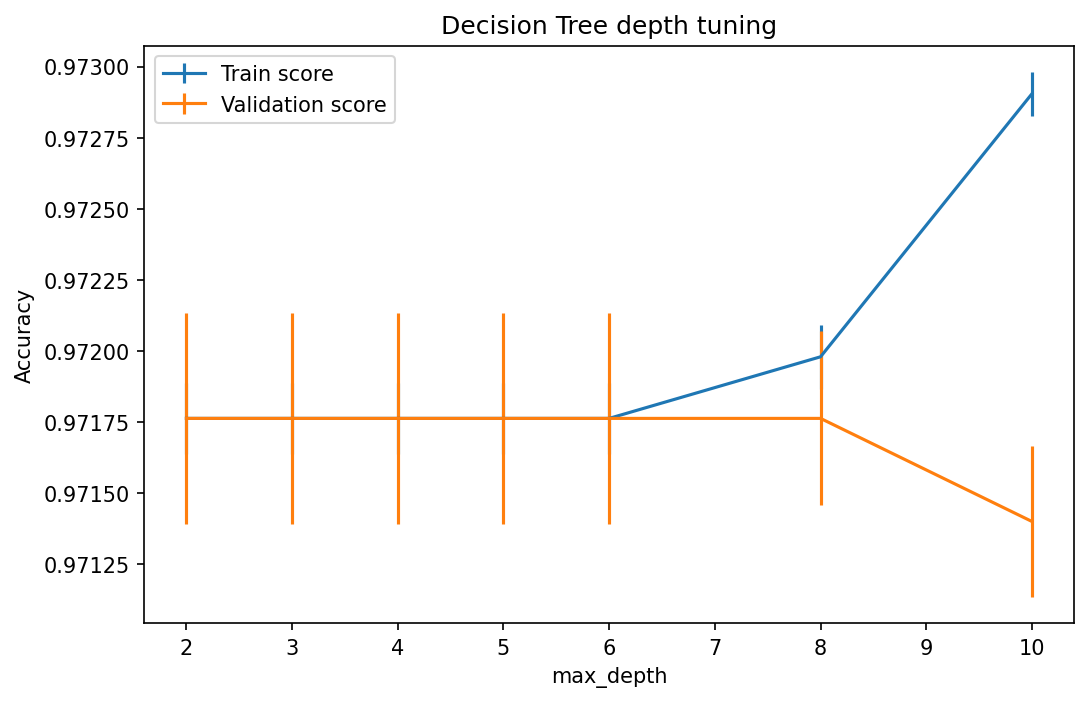

In [ ]:
cv_results_df = pd.DataFrame(grid_dt.cv_results_)

plt.figure(figsize=(8,5))
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_train_score'],
             yerr=cv_results_df['std_train_score']/np.sqrt(4),
             label='Train score')
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_test_score'],
             yerr=cv_results_df['std_test_score']/np.sqrt(4),
             label='Validation score')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree depth tuning')
plt.legend()
plt.show()

**Nhiệm vụ 3: Xây dựng rừng cây (Random Forest)**
1. Tạo mô hình Random Forest và GridSearchCV

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_params = {'n_estimators':list(range(10,110,10))}

cv_rf = GridSearchCV(rf,
                     param_grid=rf_params,
                     scoring='accuracy',
                     cv=4,
                     return_train_score=True,
                     verbose=1)
cv_rf.fit(X_train, y_train)

print("Best params:", cv_rf.best_params_)
print("Best CV score:", cv_rf.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


KeyboardInterrupt: 

2. Vẽ biểu đồ số cây trong rừng

In [ ]:
cv_rf_results = pd.DataFrame(cv_rf.cv_results_)

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(cv_rf_results['param_n_estimators'], cv_rf_results['mean_fit_time'], '-o')
ax[0].set_xlabel('Number of trees')
ax[0].set_ylabel('Mean fit time (s)')

ax[1].errorbar(cv_rf_results['param_n_estimators'],
               cv_rf_results['mean_test_score'],
               yerr=cv_rf_results['std_test_score']/np.sqrt(4))
ax[1].set_xlabel('Number of trees')
ax[1].set_ylabel('Accuracy (Validation)')

plt.tight_layout()
plt.show()

3. Feature importance

In [ ]:
feat_imp_df = pd.DataFrame({
    'Importance': cv_rf.best_estimator_.feature_importances_
}, index=X.columns)

feat_imp_df.sort_values('Importance', ascending=True).plot.barh(figsize=(8,6))
plt.title("Feature Importances (Random Forest)")
plt.show()

**2.2.3. Bài tập thực hành 1**

Xây dựng mô hình từ giải thuật SVM trên dữ liệu bệnh tiểu đường. Dữ liệu lấy từ
https://www.kaggle.com/code/tumpanjawat/diabetes-eda-random-forest-hp


1. Import và nhập dữ liệu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# đọc dữ liệu
df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Kích thước dữ liệu:", df.shape)
print(df.info())
print(df.head())
print("\nSố lượng nhãn:\n", df['diabetes'].value_counts())


Kích thước dữ liệu: (27528, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               27528 non-null  object 
 1   age                  27528 non-null  float64
 2   hypertension         27528 non-null  int64  
 3   heart_disease        27528 non-null  int64  
 4   smoking_history      27528 non-null  object 
 5   bmi                  27528 non-null  float64
 6   HbA1c_level          27528 non-null  float64
 7   blood_glucose_level  27528 non-null  int64  
 8   diabetes             27528 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.9+ MB
None
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0  

2. Xử lý dữ liệu

In [ ]:
# Kiểm tra missing
print("\nMissing values:\n", df.isnull().sum())

# Nếu có missing thì fill bằng median (ở đây dataset thường không có missing)
df = df.fillna(df.median(numeric_only=True))

# Encode cột object (ví dụ: gender, smoking_history)
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Chuẩn hóa dữ liệu
X = df.drop('diabetes', axis=1)
y = df['diabetes']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Train: (22022, 8) Test: (5506, 8)


3. Huấn luyện mô hình SVM cơ bản


In [ ]:
X = data.drop('Purchased', axis=1)   # bỏ cột nhãn
y = data['Purchased']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Gender'], drop_first=True) # Assuming 'Gender' is the only categorical column here. Adjust if needed.

# Chia train/test theo tỉ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape, " Testing size:", X_test.shape)

Training size: (320, 4)  Testing size: (80, 4)


4. Đánh giá mô hình


Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5034
           1       0.96      0.63      0.76       472

    accuracy                           0.97      5506
   macro avg       0.96      0.81      0.87      5506
weighted avg       0.97      0.97      0.96      5506



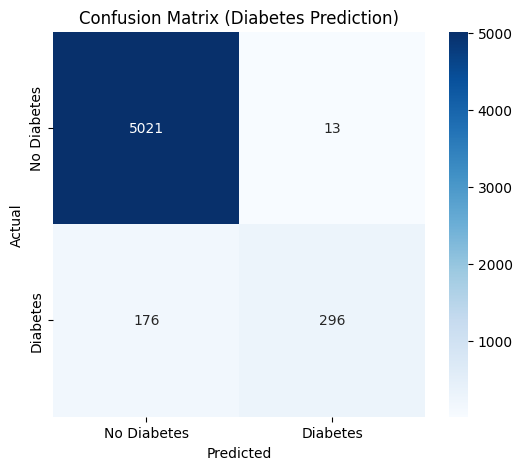

In [ ]:
y_pred = clf.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes','Diabetes'],
            yticklabels=['No Diabetes','Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Diabetes Prediction)")
plt.show()

5. Tìm kernel tối ưu

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm = None
best_acc = -1
best_kernel = None

for k in kernels:
    model = svm.SVC(kernel=k, random_state=42)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"Kernel={k:7s} | Validation acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_svm = model
        best_kernel = k

print("\nBest kernel:", best_kernel, "with Validation accuracy:", best_acc)

Kernel=linear  | Validation acc=0.9648
Kernel=poly    | Validation acc=0.9675
Kernel=rbf     | Validation acc=0.9657
Kernel=sigmoid | Validation acc=0.9148

Best kernel: poly with Validation accuracy: 0.9674900108972031


6. GridSearchCV tìm tham số tốt nhất


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Chỉ chọn kernel cơ bản + ít giá trị C và gamma
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Đánh giá trên tập test
y_pred_grid = grid.predict(X_test)
print(classification_report(y_test, y_pred_grid))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9634003267082308
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5034
           1       0.94      0.65      0.77       472

    accuracy                           0.97      5506
   macro avg       0.96      0.82      0.87      5506
weighted avg       0.97      0.97      0.96      5506



**2.2.4. Bài tập thực hành 2**

Xây dựng mô hình từ giải thuật SVM trên dữ liệu các con thú trong rừng. Dữ liệu lấy từ
https://www.kaggle.com/code/kareemellithy/animal-condition-predict-svm-knn

1. Import thư viện

In [ ]:
# 1. Import thư viện
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

1. Import dữ liệu

In [ ]:
df = pd.read_csv("data.csv")

print("Kích thước dữ liệu:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Kích thước dữ liệu: (871, 7)
  AnimalName symptoms1             symptoms2 symptoms3    symptoms4  \
0        Dog     Fever              Diarrhea  Vomiting  Weight loss   
1        Dog     Fever              Diarrhea  Coughing    Tiredness   
2        Dog     Fever              Diarrhea  Coughing     Vomiting   
3        Dog     Fever  Difficulty breathing  Coughing     Lethargy   
4        Dog     Fever              Diarrhea  Coughing     Lethargy   

     symptoms5 Dangerous  
0  Dehydration       Yes  
1        Pains       Yes  
2     Anorexia       Yes  
3     Sneezing       Yes  
4     Blue Eye       Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    objec

3. Tách feature và target



In [ ]:
# Ở dataset này cột "Dangerous" là nhãn (tình trạng động vật)
# Handle missing values in the target variable
df.dropna(subset=['Dangerous'], inplace=True)

X = df.drop("Dangerous", axis=1)
y = df["Dangerous"]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5'], drop_first=True)


# Chia dữ liệu train/test 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, " Test set:", X_test.shape)

Train set: (695, 1147)  Test set: (174, 1147)


4. Mô hình SVM cơ bản

In [ ]:
clf = svm.SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print("Training accuracy:", train_acc)
print("Validation accuracy:", test_acc)

Training accuracy: 1.0
Validation accuracy: 1.0


5. Đánh giá mô hình

In [ ]:
y_pred = clf.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[  4   0]
 [  0 170]]

Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         4
         Yes       1.00      1.00      1.00       170

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174



6. GridSearchCV tìm kernel & tham số tốt nhất

In [ ]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"]
}
grid = GridSearchCV(
    svm.SVC(probability=True),
    param_grid=params,
    scoring="accuracy",
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

best_svm = grid.best_estimator_
final_acc = best_svm.score(X_test, y_test)
print("Test Accuracy with Best Params:", final_acc)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Accuracy: 0.9870440502292207
Test Accuracy with Best Params: 1.0


7. Ma trận nhầm lẫn với mô hình tối ưu

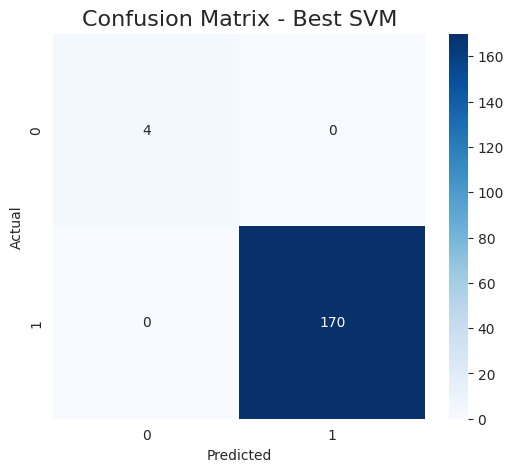

In [ ]:
y_pred_best = best_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best SVM", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**2.3.3. Bài tập thực hành 1**

Xây dựng mô hình Naïve ngây thơ trên tập dữ liệu hành vi của khách hàng lấy tại https://www.kaggle.com/code/arezalo/customer-behaviour-prediction-naive-bayes


Nhiệm vụ 1: Phân loại sử dụng Naive Bayes

1. Import thư viện và nạp dữ liệu

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Đọc dữ liệu
data = pd.read_csv("Customer_Behaviour.csv")

print("Kích thước dữ liệu:", data.shape)
print("\nThông tin dữ liệu:")
print(data.info())
print("\n5 dòng đầu:")
print(data.head())


Kích thước dữ liệu: (400, 5)

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None

5 dòng đầu:
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0


2. Xử lý dữ liệu trước khi xây dựng mô hình

In [ ]:
# Giả sử cột mục tiêu là 'Purchased'
X = data.drop('Purchased', axis=1)   # bỏ cột nhãn
y = data['Purchased']

# Chia train/test theo tỉ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape, " Testing size:", X_test.shape)


Training size: (320, 4)  Testing size: (80, 4)


3. Xây dựng mô hình Naïve Bayes (sử dụng GaussianNB cho dữ liệu số)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit và transform dữ liệu train
X_train_scaled = scaler.fit_transform(X_train)

# Transform dữ liệu test
X_test_scaled = scaler.transform(X_test)

# Huấn luyện mô hình Naïve Bayes (sử dụng GaussianNB cho dữ liệu số)
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

print("\nĐộ chính xác trên tập train:", nb.score(X_train_scaled, y_train))
print("Độ chính xác trên tập test:", nb.score(X_test_scaled, y_test))


Độ chính xác trên tập train: 0.9
Độ chính xác trên tập test: 0.875


4. Dự đoán và đánh giá mô hình

In [ ]:
y_pred = nb.predict(X_test)

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Báo cáo phân loại chi tiết
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.64

Confusion Matrix:
 [[51  0]
 [29  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        51
           1       0.00      0.00      0.00        29

    accuracy                           0.64        80
   macro avg       0.32      0.50      0.39        80
weighted avg       0.41      0.64      0.50        80



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

5. Trực quan hóa ma trận Confusion Matrix - Naive Bayes




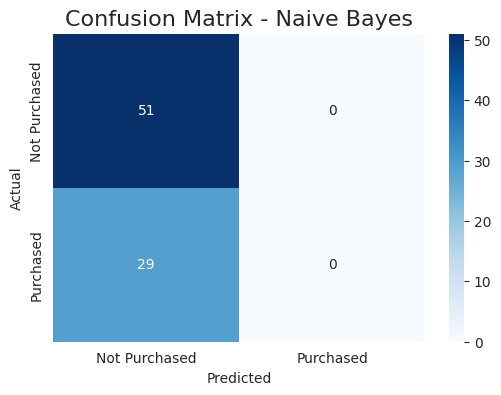

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Purchased", "Purchased"],
            yticklabels=["Not Purchased", "Purchased"])
plt.title("Confusion Matrix - Naive Bayes", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**2.3.4. Bài tập thực hành 2**

Xây dựng mô hình Naïve ngây thơ trên tập dữ liệu mushroom. Dữ liệu lấy tại https://www.kaggle.com/datasets/uciml/mushroom-classification/data

1. Import thư viện

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

2. Nạp dữ liệu

In [ ]:
df = pd.read_csv("mushrooms.csv")
print("Kích thước dữ liệu:", df.shape)
print(df.head())

Kích thước dữ liệu: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w  

3. Tiền xử lý dữ liệu

In [ ]:
# Label Encoding cho từng cột
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

# Xác định X và y
X = df.drop("class", axis=1)
y = df["class"]

# Chia dữ liệu train/test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Xây dựng mô hình Naïve Bayes

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

5. Đánh giá mô hình

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8073846153846154

Confusion Matrix:
 [[792  51]
 [262 520]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.84       843
           1       0.91      0.66      0.77       782

    accuracy                           0.81      1625
   macro avg       0.83      0.80      0.80      1625
weighted avg       0.83      0.81      0.80      1625

